##### Copyright 2020 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License").
<!--
    Licensed to the Apache Software Foundation (ASF) under one
    or more contributor license agreements.  See the NOTICE file
    distributed with this work for additional information
    regarding copyright ownership.  The ASF licenses this file
    to you under the Apache License, Version 2.0 (the
    "License"); you may not use this file except in compliance
    with the License.  You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

    Unless required by applicable law or agreed to in writing,
    software distributed under the License is distributed on an
    "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
    KIND, either express or implied.  See the License for the
    specific language governing permissions and limitations
    under the License.
-->

## Introduction
This notebook compares the following time series metrics calculated using two different frameworks:
- 60 seconds [Moving Average](https://en.wikipedia.org/wiki/Moving_average)
- [Standard Deviation](https://en.wikipedia.org/wiki/Standard_deviation) over 60 second rolling window

Using one day worth of forex tick data, for the EUR/USD currency pair, extracted from a public API and resampled to 5 seconds periods.

The two frameworks compared are:
1. The new [Apache Beam time series framework](https://github.com/GoogleCloudPlatform/dataflow-sample-applications/tree/notebook/timeseries-streaming/timeseries-java-applications), which includes
the [metrics library](https://github.com/GoogleCloudPlatform/dataflow-sample-applications/tree/notebook/timeseries-streaming/timeseries-java-applications/TimeSeriesMetricsLibrary) available out of the box in Java SDK
2. The [Pandas](https://pandas.pydata.org/) and [Numpy](https://numpy.org/) libraries available in Python SDK, as the defacto tools for data manipulation of time series data in [vectorised](https://en.wikipedia.org/wiki/Array_programming) form

## Prerequisites
- GCP project with the [BigQuery](https://cloud.google.com/bigquery) API enabled to store results, and [Dataflow](https://cloud.google.com/dataflow) API enabled to compute time series metrics at scale
- Google Cloud SDK [installed](https://cloud.google.com/sdk/docs/install) and [configured](https://cloud.google.com/sdk/docs/initializing) 

## Setup
Assuming you are reading this from Github:
- Clone this repository locally:

 ```clone git https://github.com/GoogleCloudPlatform/dataflow-sample-applications```

- Install Java 1.8, Gradle and Python 3.x

- Create Python Virtual or Conda Environment, e.g. for Conda: ```conda create --name timeseriesanalysis-is-cool python=3.7 jupyterlab```

- Run Jupyter notebook or lab to open this notebook

- Execute the below cell to install the required dependencies

In [ ]:
!conda install -c conda-forge google-cloud-bigquery google-cloud-bigquery-storage pyarrow pandas numpy matplotlib bokeh -y

## Using the new Apache Beam time series java framework in Java to compute metrics at scale in GCP Dataflow
In this case we call a gradle command to execute the Java pipeline to read and compute the metrics in scope at scale in Dataflow, PLEASE: Replace `<GCPPROJECT>`, `<REGION>`, `<DATASET>`, `<TABLE>` , `<GCPTMPLOCATION>` and `<TMPLOCATION>` parameters accordingly:

In [ ]:
!gradle -p ../../timeseries-java-applications forex_example --args='--resampleSec=5 --windowSec=60 --runner=DataflowRunner --workerMachineType=n1-standard-4 --project=<GCPPROJECT> --region=<REGION> --bigQueryTableForTSAccumOutputLocation=<GCPPROJECT>:<DATASET>.<TABLE> --gcpTempLocation=<GCPTMPLOCATION> --tempLocation=<TMPLOCATION> --inputPath=<INPUTDATASETLOCATION>'

`--resampleSec` and `--windowSec` parameters indicate the sample period in seconds, e.g., 5, and the rolling window period to use to compute the metric in seconds, e.g., 60.

## Reading results from BigQuery and loading in Pandas Dataframes
- With the above command we submitted a Beam Java pipeline to Dataflow to calculate all the [metrics currently implemented](https://github.com/GoogleCloudPlatform/dataflow-sample-applications/tree/master/timeseries-streaming/timeseries-java-applications/TimeSeriesMetricsLibrary), including the ones in scope (Moving Average and Standard Deviation), in the next steps we would query BigQuery and load the results in a Pandas Dataframe for comparison.
- We first need to be able to authenticate in GCP to read the data from BigQuery (Please ensure you have Google Cloud SDK [installed](https://cloud.google.com/sdk/docs/install) and [configured](https://cloud.google.com/sdk/docs/initializing) with the correct project)

In [6]:
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(credentials=credentials, project=your_project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [8]:
# Download results from BigQuery after the Beam pipeline finishes processing the time series data
query_string_60m = """
WITH BID_MA60_T AS (
    SELECT lower_window_boundary, upper_window_boundary, 
    (SELECT dbl_data from UNNEST(data) WHERE metric = 'SIMPLE_MOVING_AVERAGE') AS BID_MA60_BQ
    FROM `<GCPPROJECT>.<DATASET>.<TABLE>`
    WHERE timeseries_minor_key = 'BID'
)

SELECT * from BID_MA60_T
"""

bid_ma60_df = (
    bqclient.query(query_string_60m)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
).sort_values(by=['upper_window_boundary'])
bid_ma60_df.index = pd.to_datetime(bid_ma60_df['upper_window_boundary'])
bid_ma60_df.drop(columns=['upper_window_boundary', 'lower_window_boundary'],inplace=True)

query_string_stddev = """
WITH BID_STDDEV_T AS (
    SELECT lower_window_boundary, upper_window_boundary, 
    (SELECT dbl_data from UNNEST(data) WHERE metric = 'STANDARD_DEVIATION') AS BID_STDDEV_BQ
    FROM `<GCPPROJECT>.<DATASET>.<TABLE>`
    WHERE timeseries_minor_key = 'BID'
)

SELECT * from BID_STDDEV_T
"""

bid_std_dev_df = (
    bqclient.query(query_string_stddev)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
).sort_values(by=['upper_window_boundary'])

bid_std_dev_df.index = pd.to_datetime(bid_std_dev_df['upper_window_boundary'])
bid_std_dev_df.drop(columns=['upper_window_boundary', 'lower_window_boundary'],inplace=True)

In [9]:
# Showing Moving Average sample
bid_ma60_df

,BID_MA60_BQ
upper_window_boundary,
2020-05-11 00:00:05+00:00,1.083749
2020-05-11 00:00:10+00:00,1.083751
2020-05-11 00:00:15+00:00,1.083760
2020-05-11 00:00:20+00:00,1.083758
2020-05-11 00:00:25+00:00,1.083747
...,...
2020-05-11 23:59:40+00:00,1.080886
2020-05-11 23:59:45+00:00,1.080885
2020-05-11 23:59:50+00:00,1.080887


In [10]:
# Showing Moving Average sample
bid_std_dev_df

,BID_STDDEV_BQ
upper_window_boundary,
2020-05-11 00:00:05+00:00,0.000000
2020-05-11 00:00:10+00:00,0.000030
2020-05-11 00:00:15+00:00,0.000028
2020-05-11 00:00:20+00:00,0.000030
2020-05-11 00:00:25+00:00,0.000036
...,...
2020-05-11 23:59:40+00:00,0.000005
2020-05-11 23:59:45+00:00,0.000004
2020-05-11 23:59:50+00:00,0.000007


## Using the Pandas Dataframe and Numpy APIs to compute the metrics
In this case we will leverage the data processing Python libraries directly, we first read the original dataset.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


eurusd = pd.read_csv("../../timeseries-java-applications/Examples/src/main/resources/EURUSD-2020-05-11_2020-05-11.csv",
                     index_col=1, names=["Pair", "Timestamp", "Ask", "Bid", "Ask Volume", "Bid Volume"], header=None)
eurusd.index = pd.to_datetime(eurusd.index)

In order to calculate the metrics in Pandas using the same constraints we need to:
1. [resample()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) the time series datapoints to every 5 seconds
2. Do forward filling with the [fillna(method='ffill')](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) method to fill the gaps accordingly
3. Apply [rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) window
4. Aggregate by applying the Numpy [mean()](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) and [std()](https://numpy.org/doc/stable/reference/generated/numpy.std.html) methods respectively

In [13]:
eurusd_bid_ma60 = eurusd.rename(columns={"Bid": "Bid MA60 Pandas"})\
                        .resample("5S")\
                        .fillna(method='ffill')['Bid MA60 Pandas']\
                        .rolling(window=12, min_periods=1)\
                        .apply(lambda x: np.mean(x))

In [14]:
eurusd_bid_stddev = eurusd.rename(columns={"Bid": "Bid StdDev Pandas"})\
                          .resample("5S")\
                          .fillna(method='ffill')['Bid StdDev Pandas']\
                          .rolling(window=12, min_periods=1)\
                          .apply(lambda x: np.std(x))

Once we have the moving average and standard deviation calculated in both frameworks we can do:
1. Convert the dataframes generated from BigQuery to UTC
2. Join the results from the two frameworks for comparisson
3. Create a Delta metric to visualise how close the values are
4. Quick visualization to compare the two metrics

## Comparing results

<AxesSubplot:xlabel='upper_window_boundary'>

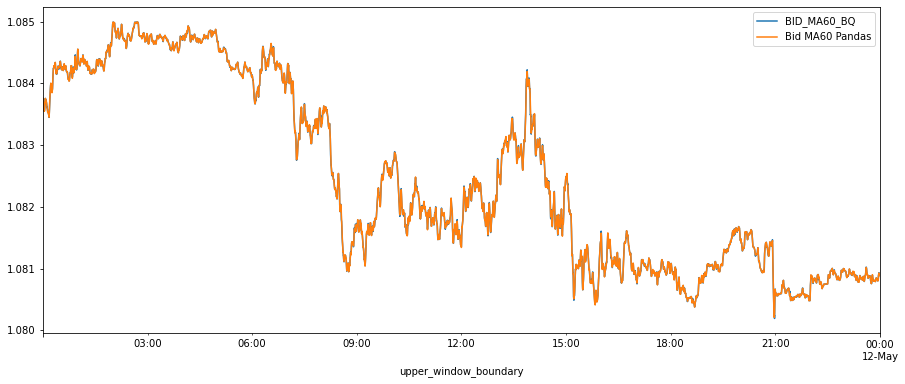

In [15]:
bid_ma60_df_utc = bid_ma60_df.tz_convert(None)
bid_ma60_df_utc_join = bid_ma60_df_utc.join(eurusd_bid_ma60)
bid_ma60_df_utc_join['Delta'] = bid_ma60_df_utc_join["Bid MA60 Pandas"] - bid_ma60_df_utc_join["BID_MA60_BQ"]
bid_ma60_df_utc_join[['BID_MA60_BQ','Bid MA60 Pandas']].plot(figsize=(15,6))

<AxesSubplot:xlabel='upper_window_boundary'>

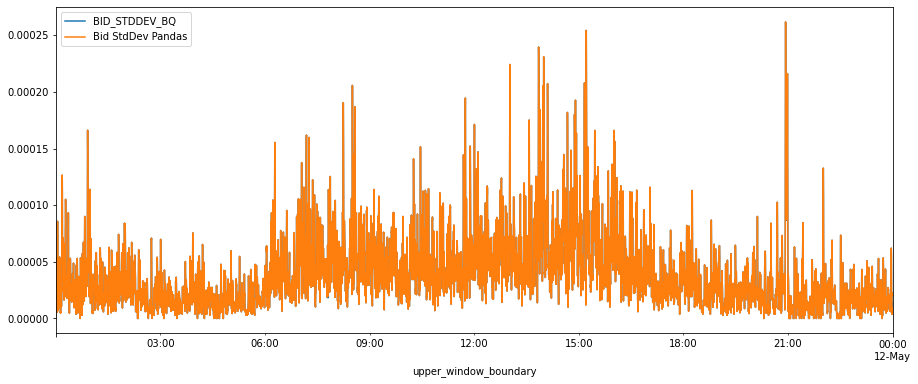

In [17]:
bid_std_dev_df_utc = bid_std_dev_df.tz_convert(None)
bid_std_dev_df_utc_join = bid_std_dev_df_utc.join(eurusd_bid_stddev)
bid_std_dev_df_utc_join['Delta'] = bid_std_dev_df_utc_join["Bid StdDev Pandas"] - bid_std_dev_df_utc_join["BID_STDDEV_BQ"]
bid_std_dev_df_utc_join[['BID_STDDEV_BQ','Bid StdDev Pandas']].plot(figsize=(15,6))

We can also sample the joined dataframes to compare the two

In [18]:
bid_ma60_df_utc_join

,BID_MA60_BQ,Bid MA60 Pandas,Delta
upper_window_boundary,,,
2020-05-11 00:00:05,1.083749,1.083720,-2.875000e-05
2020-05-11 00:00:10,1.083751,1.083750,-1.176471e-06
2020-05-11 00:00:15,1.083760,1.083760,-4.000000e-07
2020-05-11 00:00:20,1.083758,1.083750,-7.575758e-06
2020-05-11 00:00:25,1.083747,1.083738,-8.521739e-06
...,...,...,...
2020-05-11 23:59:40,1.080886,1.080889,3.611111e-06
2020-05-11 23:59:45,1.080885,1.080888,3.333333e-06
2020-05-11 23:59:50,1.080887,1.080890,3.333333e-06


In [19]:
bid_std_dev_df_utc_join

,BID_STDDEV_BQ,Bid StdDev Pandas,Delta
upper_window_boundary,,,
2020-05-11 00:00:05,0.000000,0.000000,0.000000e+00
2020-05-11 00:00:10,0.000030,0.000030,-2.550924e-17
2020-05-11 00:00:15,0.000028,0.000028,-2.875256e-11
2020-05-11 00:00:20,0.000030,0.000030,-2.550924e-17
2020-05-11 00:00:25,0.000036,0.000036,-3.060838e-17
...,...,...,...
2020-05-11 23:59:40,0.000005,0.000005,-3.351405e-11
2020-05-11 23:59:45,0.000004,0.000004,-2.003748e-11
2020-05-11 23:59:50,0.000007,0.000007,-3.218809e-11


We can see at a first glance that the Standard Deviation metric is almost identical between the two frameworks, the moving average deviates slightly more.

This is caused by the [round-off error](https://en.wikipedia.org/wiki/Round-off_error#:~:text=A%20roundoff%20error%2C%20also%20called,finite%2Dprecision%2C%20rounded%20arithmetic.) between Java [BigDecimals](https://docs.oracle.com/javase/8/docs/api/java/math/BigDecimal.html) vs Python [Float](https://docs.python.org/3/tutorial/floatingpoint.html) numerical data types. In the case of moving average the difference is higher as there are values at both sides of the decimal point, for more details [The Perils of Floating Point](http://www.lahey.com/float.htm).

We can also use the Bokeh library to enable interactive graphs, so we can interact with the results to find areas where the delta is bigger.

In [ ]:
import numpy as np

from bokeh.io import show, output_notebook
from bokeh.layouts import column, gridplot
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure

dates = np.array(bid_ma60_df_utc_join.index, dtype=np.datetime64)


p1 = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[1500], dates[2500]))

p1.line(dates, bid_ma60_df_utc_join['BID_MA60_BQ'], color='#A6CEE3', legend_label='Bid MA60 BQ')
p1.line(dates, bid_ma60_df_utc_join['Bid MA60 Pandas'], color='#FB9A99', legend_label='Bid MA60 Pandas')
p1.yaxis.axis_label = 'Price MA60'

p2 = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=p1.x_range)

p2.line(dates, bid_ma60_df_utc_join['Delta'], color='#A6CEE3', legend_label='Delta')
p2.yaxis.axis_label = 'Delta'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p1.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p1.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line(dates, bid_ma60_df_utc_join['BID_MA60_BQ'], color='#A6CEE3')
select.line(dates, bid_ma60_df_utc_join['Bid MA60 Pandas'], color='#FB9A99')
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool
output_notebook()
show(column(p1, p2, select))

![title](img/MA60.png)

In [ ]:
import numpy as np

from bokeh.io import show, output_notebook
from bokeh.layouts import column, gridplot
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure

dates = np.array(bid_std_dev_df_utc_join.index, dtype=np.datetime64)


p1 = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[1500], dates[2500]))

p1.line(dates, bid_std_dev_df_utc_join['BID_STDDEV_BQ'], color='#A6CEE3', legend_label='Bid STDDEV BQ')
p1.line(dates, bid_std_dev_df_utc_join['Bid StdDev Pandas'], color='#FB9A99', legend_label='Bid StdDev Pandas')
p1.yaxis.axis_label = 'Standard Deviation'

p2 = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=p1.x_range)

p2.line(dates, bid_std_dev_df_utc_join['Delta'], color='#A6CEE3', legend_label='Delta')
p2.yaxis.axis_label = 'Delta'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p1.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p1.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line(dates, bid_std_dev_df_utc_join['BID_STDDEV_BQ'], color='#A6CEE3')
select.line(dates, bid_std_dev_df_utc_join['Bid StdDev Pandas'], color='#FB9A99')
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool
output_notebook()
show(column(p1, p2, select))

![title](img/STDDEV.png)

## Filling the gaps
As wrap up, let's check how the gap forward filling feature is applied in both frameworks before the metrics are calculated:

1. We start first with the results from the Time Series Beam framework stored in BigQuery already

In [21]:
query_string_last = """
WITH LAST AS (
    SELECT lower_window_boundary, upper_window_boundary, 
    (SELECT dbl_data from UNNEST(data) WHERE metric = 'LAST') AS LAST
    FROM `<GCPPROJECT>.<DATASET>.<TABLE>`
    WHERE timeseries_minor_key = 'BID'
)

SELECT * from LAST
"""

last_bq = (
    bqclient.query(query_string_last)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
).sort_values(by=['upper_window_boundary'])

last_bq.index = pd.to_datetime(last_bq['upper_window_boundary'])

last_bq.drop(columns=['upper_window_boundary', 'lower_window_boundary'],inplace=True)

In [22]:
last_bq

,LAST
upper_window_boundary,
2020-05-11 00:00:05+00:00,1.08372
2020-05-11 00:00:10+00:00,1.08378
2020-05-11 00:00:15+00:00,1.08378
2020-05-11 00:00:20+00:00,1.08372
2020-05-11 00:00:25+00:00,1.08369
...,...
2020-05-11 23:59:40+00:00,1.08088
2020-05-11 23:59:45+00:00,1.08089
2020-05-11 23:59:50+00:00,1.08091


In [ ]:
import numpy as np

from bokeh.io import show, output_notebook
from bokeh.layouts import column, gridplot
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure

dates_unsampled = np.array(eurusd.index, dtype=np.datetime64)

dates_resampled = np.array(last_bq.index, dtype=np.datetime64)

# We position the graph towards the end of day to show a quiet period when forward filling is necessary
p1 = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates_unsampled[dates_unsampled.size-100], dates_unsampled[dates_unsampled.size-1]))

p1.circle(dates_unsampled, eurusd['Bid'], color='#A6CEE3', legend_label='Bid unsampled')
p1.circle(dates_resampled, last_bq['LAST'], color='#FB9A99', legend_label='Bid downsampled')
p1.yaxis.axis_label = 'Downsampling'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p1.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p1.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line(dates_unsampled, eurusd['Bid'], color='#A6CEE3')
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool
output_notebook()
show(column(p1, select))

In [47]:
# from bokeh.io import export_png

# export_png(column(p1, select), filename="img/FILLINGBQ.png")

![title](img/FILLINGBQ.png)

We can see how the unsampled data points are less frequent, so the resampled data points are forward filled correctly, in this case using the LAST measure from the samples.

2. Let's repeat the exercise with the Pandas resample this time

In [17]:
last_pandas = eurusd.resample("5S").fillna(method='ffill')['Bid']

In [ ]:
import numpy as np

from bokeh.io import show, output_notebook
from bokeh.layouts import column, gridplot
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure

dates_unsampled = np.array(eurusd.index, dtype=np.datetime64)

dates_resampled = np.array(last_pandas.index, dtype=np.datetime64)

# We position the graph towards the end of day to show a quiet period when forward filling is necessary
p1 = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates_unsampled[dates_unsampled.size-100], dates_unsampled[dates_unsampled.size-1]))

p1.circle(dates_unsampled, eurusd['Bid'], color='#A6CEE3', legend_label='Bid unsampled')
p1.circle(dates_resampled, last_pandas, color='#FB9A99', legend_label='Bid downsampled')
p1.yaxis.axis_label = 'Downsampling'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p1.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p1.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line(dates_unsampled, eurusd['Bid'], color='#A6CEE3')
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool
output_notebook()
show(column(p1, select))

In [44]:
# from bokeh.io import export_png

# export_png(column(p1, select), filename="img/FILLINGPANDAS.png")

![title](img/FILLINGPANDAS.png)

We can see again the Pandas resampling with the fillna(method='ffill') option, forward fills with exactly same pattern, proving the two frameworks apply forward filling in similar way.

## What's next
- Feel free to explore the framework and build [new metrics](https://github.com/GoogleCloudPlatform/dataflow-sample-applications/tree/master/timeseries-streaming/timeseries-java-applications/TimeSeriesMetricsLibrary#creating-new-metrics-from-a-stream) for your own needs! 